# UBI-FIT (flat income tax)

For each level of a UBI, calculate the required flat income tax rate, and associated measures like poverty rate (depth) and inequality.

* Disruption: average decrease to after-tax income (also per person)
* Gini per person

*Data: CPS  |  Tax year: 2018  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'2.2.0'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

### Function to set all tax rates to the same value

In [6]:
def rt(rate, year=2019):
    return {year: rate}

In [7]:
def fit(rate):
    return {
        'II_rt1': rt(rate),
        'II_rt2': rt(rate),
        'II_rt3': rt(rate),
        'II_rt4': rt(rate),
        'II_rt5': rt(rate),
        'II_rt6': rt(rate),
        'II_rt7': rt(rate),
        'II_rt8': rt(rate),
        'PT_rt1': rt(rate),
        'PT_rt2': rt(rate),
        'PT_rt3': rt(rate),
        'PT_rt4': rt(rate),
        'PT_rt5': rt(rate),
        'PT_rt6': rt(rate),
        'PT_rt7': rt(rate),
        'PT_rt8': rt(rate),
        'CG_nodiff': {2019: True},  # Avoid specifying each CG rate.
        'AMT_rt1': rt(rate),
        'AMT_rt2': rt(0)  # This is the excess rate. Ideally remove AMT.
    }

## Data

In [8]:
recs = tc.Records.cps_constructor()

In [9]:
base = tch.calc_df(records=recs, year=2019, group_vars=['XTOT'],
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])

In [10]:
def fit_df(rate):
    # Only get after-tax income. 
    # Since only rates change, benefits will stay the same.
    reform_df = tch.calc_df(year=2019, group_vars=['XTOT'], group_n65=True,
                            metric_vars=['aftertax_income', 'XTOT'],
                            reform=fit(rate))
    reform_df['rate'] = rate
    return reform_df

In [11]:
l = []

for i in np.arange(0, 1.01, 0.05).tolist():
    print(i)
    l.append(fit_df(i))
    
fdf = pd.concat(l)

0.0
0.05
0.1
0.15000000000000002
0.2
0.25
0.30000000000000004
0.35000000000000003
0.4
0.45
0.5
0.55
0.6000000000000001
0.65
0.7000000000000001
0.75
0.8
0.8500000000000001
0.9
0.9500000000000001
1.0


## Analysis

### Calculate UBI for each FIT level

In [12]:
cur_afti = tch.weighted_sum(base, 'aftertax_income')
cur_pop = tch.weighted_sum(base, 'XTOT')

In [13]:
fdf_agg = pd.DataFrame(fdf.groupby(['rate']).apply(
    lambda x: tch.weighted_sum(x, 'aftertax_income')))
fdf_agg.columns = ['afti']
fdf_agg['rev'] = cur_afti - fdf_agg.afti
fdf_agg['ubi'] = fdf_agg.rev / cur_pop

In [14]:
def nearest(s, val):  # TODO
    """Nearest value.
    """
    diff = np.abs(s - val)
    

In [15]:
fdf_agg

,afti,rev,ubi
rate,,,
0.00,1.39e+13,-1.47e+12,-4407.17
0.05,1.35e+13,-1.07e+12,-3198.52
0.10,1.31e+13,-6.29e+11,-1889.18
0.15,1.27e+13,-1.91e+11,-572.29
0.20,1.22e+13,2.49e+11,746.74
0.25,1.18e+13,6.88e+11,2066.72
0.30,1.13e+13,1.13e+12,3387.22
0.35,1.09e+13,1.57e+12,4708.09
0.40,1.05e+13,2.01e+12,6029.18


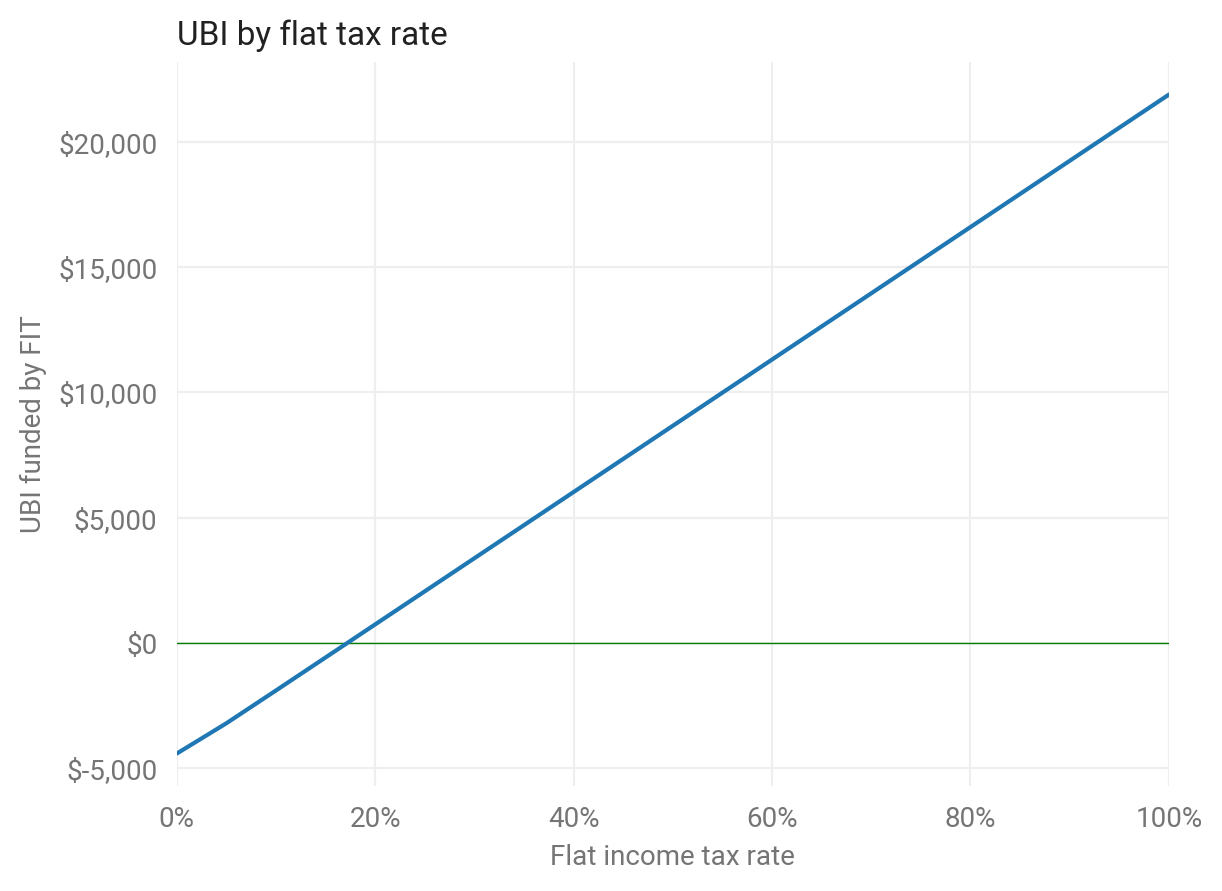

In [16]:
ax = fdf_agg.ubi.plot()
sns.despine(left=True, bottom=True)
# plt.axhline(y=cur_gini, c='gray', linewidth=0.5, zorder=-1)
# Revenue-neutral flat tax rate: 16.5%.
# plt.axvline(x=0.165, c='gray', linewidth=0.5, zorder=-1)
# Gini-neutral FIT: 20%.
# plt.axvline(x=0.2, c='gray', linewidth=0.5, zorder=-1)
plt.title('UBI by flat tax rate', loc='left')
ax.grid(color='#eeeeee')
plt.axhline(y=0, c='green', linewidth=0.5, zorder=1)
ax.set(xlabel='Flat income tax rate', ylabel='UBI funded by FIT')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
ax.yaxis.set_major_formatter(
    mpl.ticker.StrMethodFormatter('${x:,.0f}'))

In [17]:
fdf = pd.merge(fdf, pd.DataFrame(fdf_agg.ubi), left_on='rate', 
               right_index=True)

In [18]:
fdf['afti'] = fdf.aftertax_income + fdf.ubi

In [19]:
ginis = fdf.groupby('rate').apply(lambda x: tch.gini(x.afti, x.s006))

In [20]:
cur_gini = tch.gini(base.aftertax_income, base.s006)

In [21]:
print(ginis)
cur_gini

rate
0.00    0.51
0.05    0.50
0.10    0.48
0.15    0.47
0.20    0.46
0.25    0.44
0.30    0.43
0.35    0.41
0.40    0.40
0.45    0.38
0.50    0.37
0.55    0.35
0.60    0.34
0.65    0.32
0.70    0.31
0.75    0.30
0.80    0.28
0.85    0.27
0.90    0.26
0.95    0.25
1.00    0.26
dtype: float64


0.453761047487913

In [22]:
ginis - cur_gini  # `which` statement?

rate
0.00    5.63e-02
0.05    4.39e-02
0.10    3.07e-02
0.15    1.72e-02
0.20    3.54e-03
0.25   -1.05e-02
0.30   -2.47e-02
0.35   -3.92e-02
0.40   -5.40e-02
0.45   -6.89e-02
0.50   -8.40e-02
0.55   -9.92e-02
0.60   -1.14e-01
0.65   -1.29e-01
0.70   -1.44e-01
0.75   -1.58e-01
0.80   -1.72e-01
0.85   -1.84e-01
0.90   -1.94e-01
0.95   -2.00e-01
1.00   -1.99e-01
dtype: float64

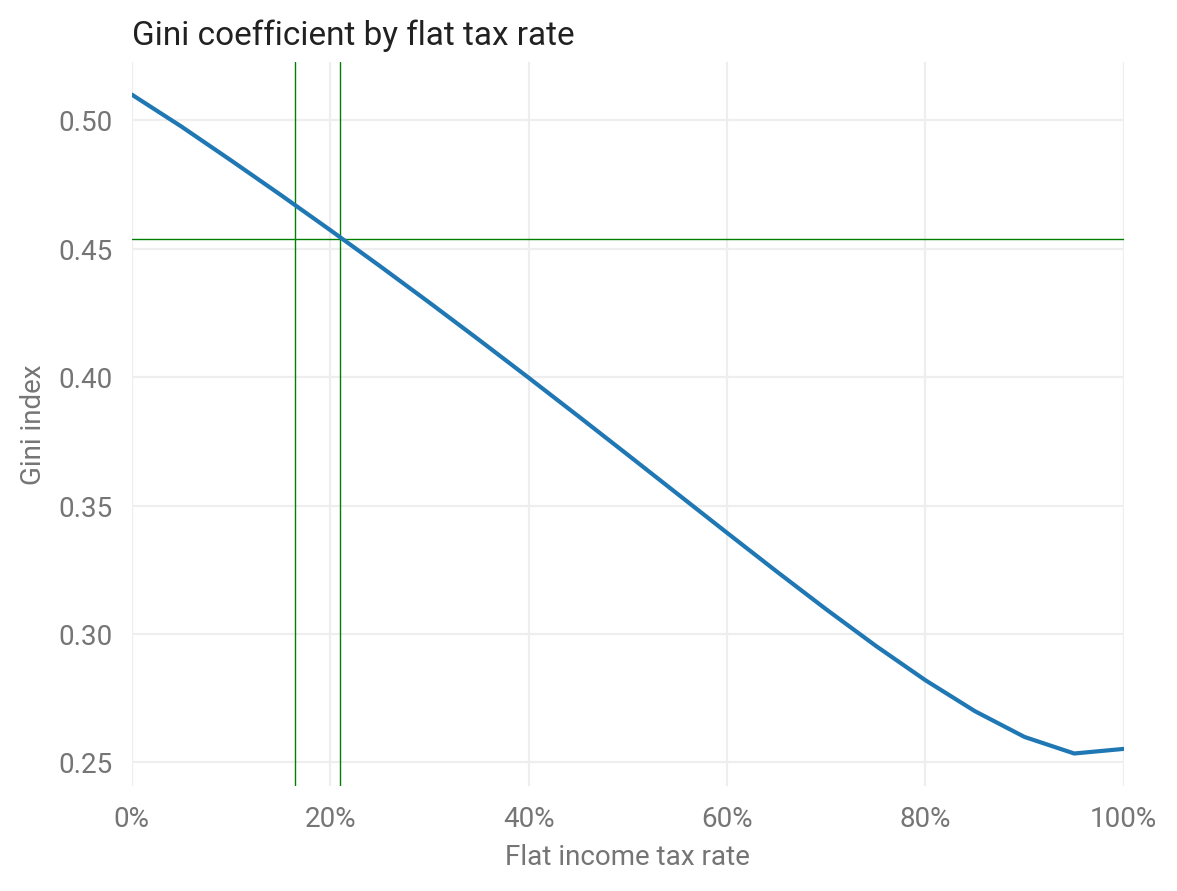

In [23]:
ax = ginis.plot()
sns.despine(left=True, bottom=True)
ax.grid(color='#eeeeee')
plt.axhline(y=cur_gini, c='green', linewidth=0.5, zorder=1)
# Revenue-neutral flat tax rate: 16.5%.
plt.axvline(x=0.165, c='green', linewidth=0.5, zorder=1)
# Gini-neutral FIT: 20%.
plt.axvline(x=0.21, c='green', linewidth=0.5, zorder=1)
ax.set(xlabel='Flat income tax rate', ylabel='Gini index')
plt.title('Gini coefficient by flat tax rate', loc='left')
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))